In [1]:
# Обработка данных
import numpy as np
import pandas as pd

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# ml-algorithms
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# MNIST dataset
from sklearn.datasets import load_digits
digits_df = load_digits()
digits_features = digits_df['data']
digits_labels = digits_df['target']

# Модуль с ф-циями, которые я написал для удобства
from extra_modules import tools

In [2]:
from importlib import reload
reload(tools)

<module 'extra_modules.tools' from '/home/vsevolod/Documents/python_stuff/mnist-generation-experiments/extra_modules/tools.py'>

## Посмотрим на различные визуализации опорных векторов

Посмотрим за что отвечают компоненты в PCA, натренированные только на 0

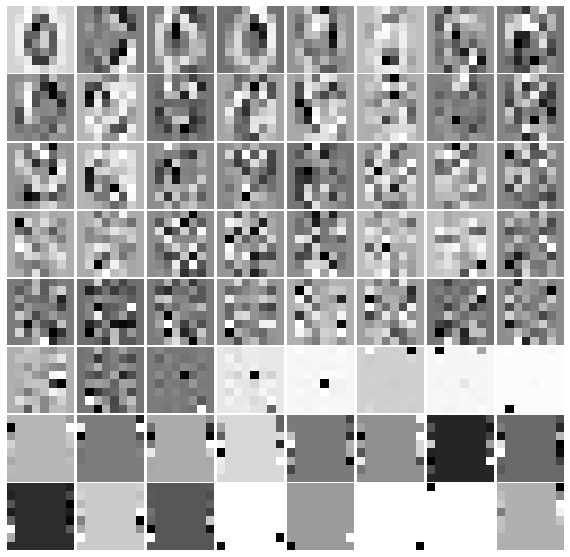

In [5]:
X_zeros = digits_features[digits_labels == 0]
pca = PCA(n_components=64)
pca.fit(X_zeros)
tools.display_rows_as_images(pca.components_);

А теперь на всех данных

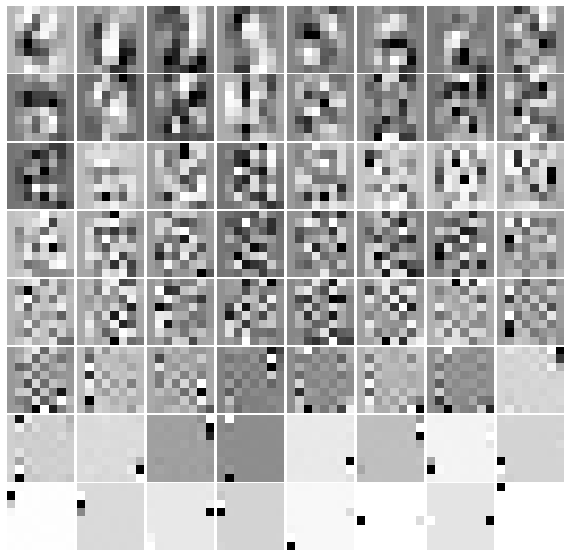

In [4]:
pca = PCA(n_components=64)
pca.fit(digits_features)
tools.display_rows_as_images(pca.components_);

## Генерация посредством усреднения цифр

Тупо усредним единицы

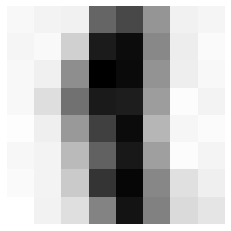

In [6]:
X_ones = digits_features[digits_labels == 1]
pca_ones = PCA(n_components=64)
pca_ones.fit(X_ones)

rng = np.random.RandomState(100)
img_1 = pca_ones.inverse_transform(rng.random((1, 64))).reshape(8, 8)
plt.axis(False)
plt.imshow(img_1, cmap='Greys')

 типовКак мы видим, это не дало никакого осмысленного результата, скорее всего это происходит потому что единицы сильно отличаются по стилю написания.

## Анализ единиц

### Первичный взгляд

In [68]:
def show_ordered_images(X, rows, cols, start=0, step=1):
    fig, axis = plt.subplots(rows, cols, figsize=(10, 10))
    fig.subplots_adjust(wspace=0.025, hspace=0.025)
    for i, ax in enumerate(np.ravel(axis)):
        index = start + i * step
        ax.imshow(X[index].reshape(8, 8),
                  cmap='Greys',
                  extent=[0, 1, 0, 1])
        ax.text(0, 0, index)
        ax.axis('off')

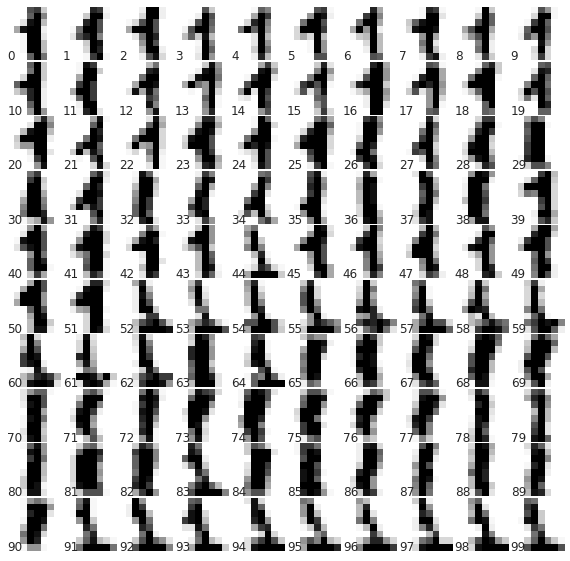

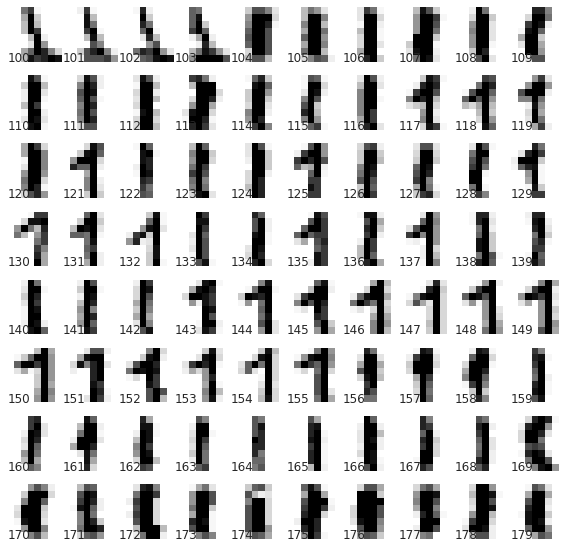

In [40]:
show_ordered_images(X_ones, 10, 10, 0, 1)
show_ordered_images(X_ones, 8, 10, 100, 1)

Из данных видно, что цифры в исходном датасете отсортированны по типу, это может облегчить процесс кластеризации цифр

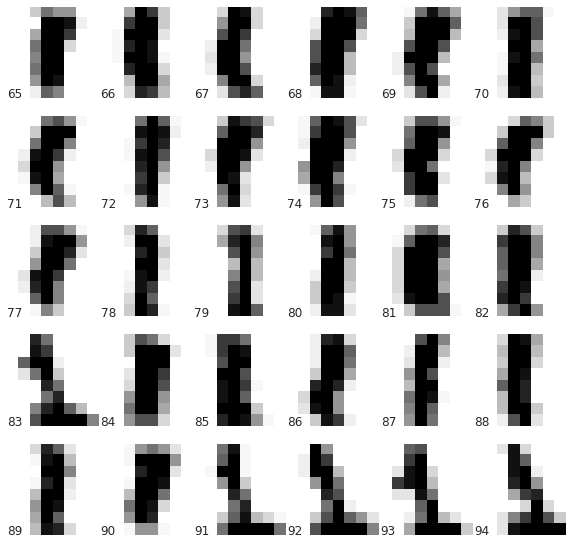

In [27]:
show_ordered_images(X_ones, 5, 6, 65, 1)

Несмотря на то что данные отсортированны мы видим, что единицы действительно очень сильно отличаются. Особенно примечательны примеры с 65 по 90

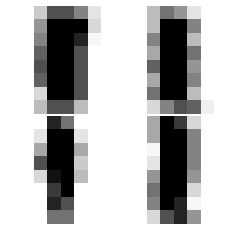

In [36]:
tools.display_rows_as_images(X_ones[[104, 105, 156, 120]], figsize=(4, 4));

Также стоит отметить, что на некоторых цифрах есть что-то похожее на шумы. Их можно попробовать убрать, используя PCA

### Используем PCA для удаления шумов

In [44]:
def filter_noises(X, save_data=0.8):
    pca = PCA(save_data)
    pca.fit(X)
    components = pca.transform(X)
    X_filtered = pca.inverse_transform(components)
    return X_filtered

In [ ]:
def plot_change_in_images(imgs_before, imgs_after):
    cols = 2
    rows = imgs_before.shape[0]
    fig, axis = plt.subplots(rows, cols, figsize=(4, 2 * rows))
    fig.subplots_adjust(wspace=0.025, hspace=0.025)
    for row in range(rows):

        axis[row, 0].imshow(imgs_before[row].reshape(8, 8),
                  cmap='Greys',
                  extent=[0, 1, 0, 1])

        axis[row, 1].imshow(imgs_after[row].reshape(8, 8),
                            cmap='Greys',
                            extent=[0, 1, 0, 1])

    axis[0, 0].set_title('Before')
    axis[0, 1].set_title('After')
    for ax in np.ravel(axis):
        ax.axis(False)

Проверим как сработала фильтрация для наших даннных

### Для 0.5

In [88]:
def placeholder(data_saved):
    X_ones_filtered = filter_noises(X_ones, data_saved)
    img_indexes = [8, 16, 34, 75, 69, 85, 169]
    before = X_ones[img_indexes]
    after = X_ones_filtered[img_indexes]
    plot_change_in_images(before, after);

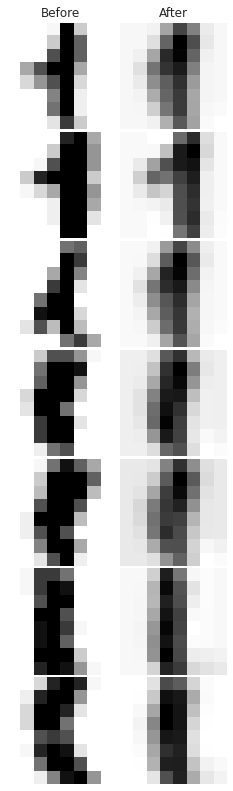

In [89]:
placeholder(0.5)

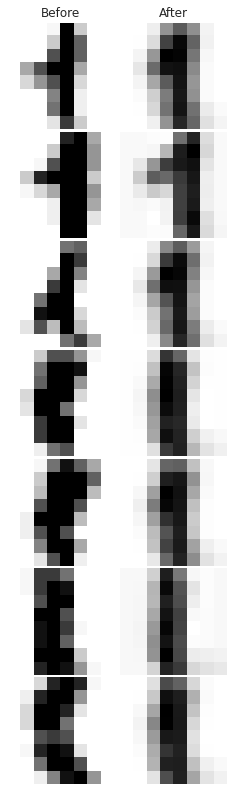

In [91]:
placeholder(0.3)